<a href="https://colab.research.google.com/github/samitha278/multilayer-perceptron-char-lm/blob/main/mlp_complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import gdown
import random

In [7]:
file_id = "1aLPTEpFPciZPYvBORlfOBSOohkwYyrqV"
url = f"https://drive.google.com/uc?id={file_id}"

output = "names.txt"
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1aLPTEpFPciZPYvBORlfOBSOohkwYyrqV
To: /content/names.txt
100%|██████████| 228k/228k [00:00<00:00, 80.5MB/s]


'names.txt'

In [12]:
words = open('names.txt','r').read().splitlines()
len(words)


stoi = {s:i+1 for i,s, in enumerate(sorted(list(set(''.join(words)))))}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

print(vocab_size)
print(itos)


27
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [14]:
block_size = 3

def build_dataset(data):

  x,y = [],[]
  for w in data:
    context_window = [0]*block_size
    for ch in w+'.':
      ix = stoi[ch]
      x.append(context_window)
      y.append(ix)
      context_window = context_window[1:] + [ix]
  x = torch.tensor(x)
  y = torch.tensor(y)

  return x,y


random.seed(278)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

In [118]:
class Linear:

  def __init__(self,shape,bias=True,g = torch.Generator().manual_seed(278)):
    m,n = shape
    self.bias = bias
    self.W = torch.randn((m,n), generator=g) / m**0.5
    self.b = torch.randn(n,generator=g) if bias else None


  def __call__(self,x):
    self.out = x @ self.W
    if self.bias:
      self.out += self.b

    return self.out


  def parameters(self):
    return [self.W] + [] if self.bias is None else [self.b]





class BatchNorm:


  def __init__(self,shape,training = True,momentum = 0.1,g = torch.Generator().manual_seed(278)):

    m,n = shape
    self.gamma = torch.ones(n, dtype=torch.float32)
    self.beta = torch.zeros(n, dtype=torch.float32)
    self.training = training
    self.momentum = momentum
    self.mean_running = torch.zeros(n, dtype=torch.float32)
    self.var_running = torch.ones(n, dtype=torch.float32)



  def __call__(self,data):

    if self.training:
      mu = data.mean(0,keepdim=True)
      sigma2 = data.var(0,keepdim=True)

      with torch.no_grad():
        self.mean_running = (1.0-self.momentum)*self.mean_running + self.momentum*mu
        self.var_running = (1.0-self.momentum)*self.var_running + self.momentum*sigma2

    else:
      mu = self.mean_running
      sigma2 = self.var_running

    xhat = (data - mu)/torch.sqrt(sigma2+1e-5)
    self.out = self.gamma * xhat  + self.beta

    return self.out


  def parameters(self):
    return [self.gamma,self.beta]



class Tanh:

  def __call__(self,data):
    return torch.tanh(data)

  def parameters(self):
    return []



class Embedding:

  def __init__(self,shape,out_shape):
    self.out_shape = out_shape
    self.weight = torch.randn(shape)

  def __call__(self,index):
    self.out = self.weight[index].view(self.out_shape)
    return self.out

  def parameters(self):
    return [self.weight]


class Sequential:

  def __init__(self,layers):
    self.layers = layers

  def __call__(self,data):
    x = data
    for layer in self.layers:
      x = layer(x)

    self.out = x
    return self.out


  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]




In [106]:
torch.manual_seed(278)

In [119]:
vector_dim = 10
batch_size = 32
n = batch_size
n_hidden = 100


shape_emb = (vocab_size,vector_dim)
shape_hidden = (block_size*vector_dim,n_hidden)
shape_out = (n_hidden,vocab_size)


model = Sequential([
    Embedding(shape_emb,(-1,shape_hidden[0])), Linear(shape_hidden) , BatchNorm(shape_hidden) , Tanh(),
    Linear(shape_out)
])


parameters = model.parameters()

print(sum(p.nelement() for p in parameters))


for param in parameters:
  param.requires_grad = True

597


In [120]:
max_iter = 100000
lossi = []


for i in range(max_iter):

  # minibatch
  ix = torch.randint(0,len(words),(32,))
  Xb = Xtr[ix]
  Yb = Ytr[ix]

  #forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits,Yb)


  #backward
  for p in parameters:
    p.grad = None

  loss.backward()


  #update

  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data -= lr* p.grad


  if i%10000 == 0:
    print(f'{i}/{max_iter} {loss}')
  lossi.append(loss)

0/100000 4.579021453857422
10000/100000 2.794410228729248
20000/100000 2.69537615776062
30000/100000 2.3633477687835693
40000/100000 2.5357558727264404
50000/100000 2.362725257873535
60000/100000 2.385233163833618
70000/100000 2.319124937057495
80000/100000 2.056785821914673
90000/100000 2.8071696758270264


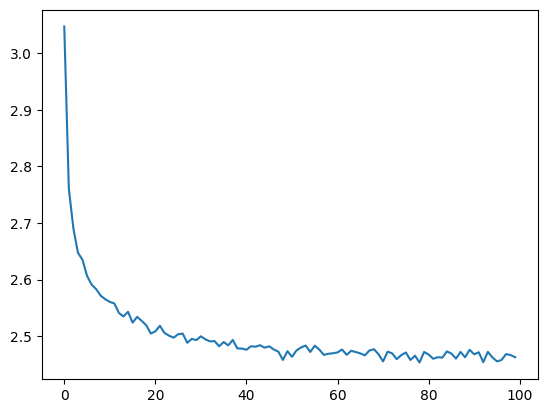

In [121]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

In [122]:
for layer in model.layers:
  layer.training = False

@torch.no_grad()

def run(x,y):
  logits = model(x)
  loss = F.cross_entropy(logits,y)
  return loss.item()


print(f'Train : {run(Xtr,Ytr)}')
print(f'Val : {run(Xdev,Ydev)}')



Train : 2.4538333415985107
Val : 2.4535791873931885


### Sample from model

In [125]:
for _ in range(50):

  context_window = [0]*3
  out = []

  while True:
    logits = model(context_window)
    probs = F.softmax(logits)

    ix = torch.multinomial(probs,1).item()

    context_window = context_window[1:] + [ix]
    out.append(itos[ix])

    if ix == 0:
      break


  print(''.join(out))


kranty.
rihla.
zeaoyarlan.
gtlieka.
koznaclsipdva.
nakidon.
mir.
nyan.
lafn.
aceg.
rauhla.
hta.
kra.
leunc.
h.
mavittsetgalii.
khiysjileah.
cim.
vebnsnstna.
tyzi.
lysn.
adiae.
an.
hpahna.
siha.
esry.
.
vcrienha.
jayber.
atua.
sraa.
pratezaalaliu.
go.
cdaeenrdsae.
iah.
hazzoy.
drsjah.
kander.
caihteensa.
kushink.
ano.
haviniania.
bih.
poaritla.
cea.
maylentshonaon.
vihe.
nsye.
jaribadi.
kuyysiv.


/tmp/ipython-input-3347058894.py:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(logits)
